In [17]:
#Install required packages
!pip install pyspark pandas matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\daksh\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [2]:
#Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, mean, col, when, count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
#Initialize Spark session
spark = SparkSession.builder.appName("ClimateChangeAnalytics").getOrCreate()

In [4]:
#Load the data
# Replace "climate_data.csv" with your actual file path
df = spark.read.csv(r"C:\Users\daksh\Downloads\archive (1)\climate_change_indicators.csv", header=True, inferSchema=True)

In [5]:
#Display basic data info
print("Dataset Overview:")
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

print("\nFirst 5 rows:")
pandas_df = df.limit(5).toPandas()
display(pandas_df)

print("\nColumn types:")
df.printSchema()

Dataset Overview:
Number of rows: 225
Number of columns: 72

First 5 rows:


,ObjectId,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate Indicator...",...,1.281,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012
1,2,Albania,AL,ALB,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate Indicator...",...,1.333,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518
2,3,Algeria,DZ,DZA,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate Indicator...",...,1.192,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688
3,4,American Samoa,AS,ASM,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate Indicator...",...,1.257,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256
4,5,"Andorra, Principality of",AD,AND,Temperature change with respect to a baseline ...,Degree Celsius,Food and Agriculture Organization of the Unite...,ECCS,Surface Temperature Change,"Environment, Climate Change, Climate Indicator...",...,0.831,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243



Column types:
root
 |-- ObjectId: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- ISO2: string (nullable = true)
 |-- ISO3: string (nullable = true)
 |-- Indicator: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- CTS_Code: string (nullable = true)
 |-- CTS_Name: string (nullable = true)
 |-- CTS_Full_Descriptor: string (nullable = true)
 |-- F1961: double (nullable = true)
 |-- F1962: double (nullable = true)
 |-- F1963: double (nullable = true)
 |-- F1964: double (nullable = true)
 |-- F1965: double (nullable = true)
 |-- F1966: double (nullable = true)
 |-- F1967: double (nullable = true)
 |-- F1968: double (nullable = true)
 |-- F1969: double (nullable = true)
 |-- F1970: double (nullable = true)
 |-- F1971: double (nullable = true)
 |-- F1972: double (nullable = true)
 |-- F1973: double (nullable = true)
 |-- F1974: double (nullable = true)
 |-- F1975: double (nullable = true)
 |-- F1976: double (nullabl

In [6]:
#Data quality check
print("\nMissing values analysis:")
year_columns = [col for col in df.columns if col.startswith('F')]

# Check for missing values
missing_stats = []
total_count = df.count()

for column in year_columns:
    missing_count = df.filter(col(column).isNull()).count()
    missing_percent = (missing_count / total_count) * 100
    if missing_percent > 0:
        missing_stats.append((column, missing_count, missing_percent))

if missing_stats:
    print("Columns with missing values:")
    for col_name, count, percent in missing_stats:
        print(f"{col_name}: {count} missing ({percent:.2f}%)")
else:
    print("No missing values found in year columns!")


Missing values analysis:
Columns with missing values:
F1961: 37 missing (16.44%)
F1962: 36 missing (16.00%)
F1963: 37 missing (16.44%)
F1964: 37 missing (16.44%)
F1965: 37 missing (16.44%)
F1966: 33 missing (14.67%)
F1967: 34 missing (15.11%)
F1968: 34 missing (15.11%)
F1969: 35 missing (15.56%)
F1970: 36 missing (16.00%)
F1971: 34 missing (15.11%)
F1972: 33 missing (14.67%)
F1973: 32 missing (14.22%)
F1974: 33 missing (14.67%)
F1975: 37 missing (16.44%)
F1976: 36 missing (16.00%)
F1977: 40 missing (17.78%)
F1978: 36 missing (16.00%)
F1979: 36 missing (16.00%)
F1980: 34 missing (15.11%)
F1981: 34 missing (15.11%)
F1982: 33 missing (14.67%)
F1983: 35 missing (15.56%)
F1984: 37 missing (16.44%)
F1985: 37 missing (16.44%)
F1986: 35 missing (15.56%)
F1987: 35 missing (15.56%)
F1988: 35 missing (15.56%)
F1989: 35 missing (15.56%)
F1990: 36 missing (16.00%)
F1991: 37 missing (16.44%)
F1992: 17 missing (7.56%)
F1993: 16 missing (7.11%)
F1994: 17 missing (7.56%)
F1995: 15 missing (6.67%)
F199

In [7]:
#Handle missing values (if any)
# Fill missing values with the average of that year
for column in year_columns:
    avg_temp = df.select(expr(f"avg({column})")).collect()[0][0]
    df = df.fillna({column: avg_temp})

print("\nMissing values handled!")


Missing values handled!


In [8]:
#Convert to pandas for analysis (since dataset is small)
pdf = df.toPandas()

# Prepare data for time series analysis
pdf_long = pdf.melt(
    id_vars=["Country"], 
    value_vars=year_columns, 
    var_name="Year", 
    value_name="Temperature"
)
pdf_long["Year"] = pdf_long["Year"].str.extract("F(\d+)").astype(int)

# Calculate global average temperature per year
avg_temp = pdf_long.groupby("Year")["Temperature"].mean().reset_index()

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\daksh\AppData\Local\Temp\ipykernel_18492\3196482125.py:11: SyntaxWarning: invalid escape sequence '\d'
  pdf_long["Year"] = pdf_long["Year"].str.extract("F(\d+)").astype(int)


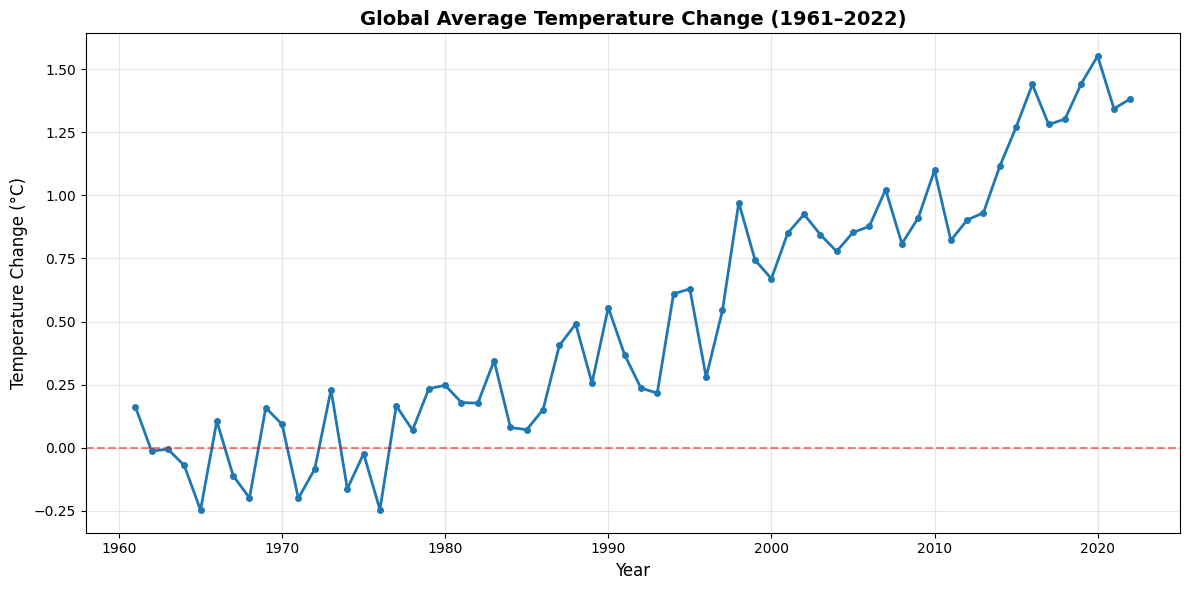

In [9]:
#Basic global temperature trend
plt.figure(figsize=(12, 6))
plt.plot(avg_temp["Year"], avg_temp["Temperature"], marker='o', linewidth=2, markersize=4)
plt.title("Global Average Temperature Change (1961–2022)", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature Change (°C)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
C:\Users\daksh\AppData\Local\Temp\ipykernel_18492\1645415702.py:36: SyntaxWarning: invalid escape sequence '\d'
  pdf_long_continent["Year"] = pdf_long_continent["Year"].str.extract("F(\d+)").astype(int)
C:\Users\daksh\AppData\Local\Temp\ipykernel_18492\1645415702.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_increases, y='Country', x='Change_1961_2022', palette='Reds_r')


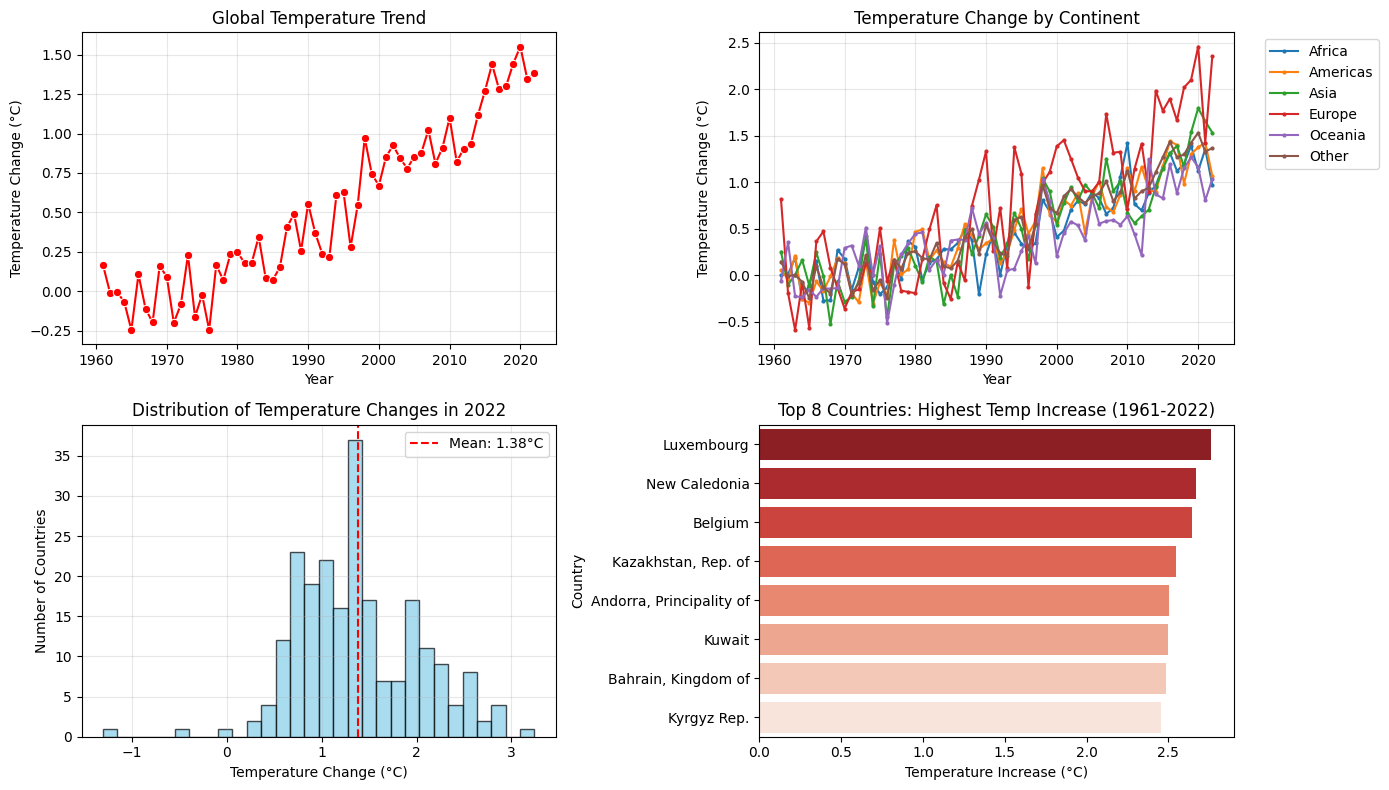

In [10]:
plt.figure(figsize=(14, 8))

# Create subplots
plt.subplot(2, 2, 1)
sns.lineplot(data=avg_temp, x="Year", y="Temperature", marker="o", color='red')
plt.title("Global Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.grid(True, alpha=0.3)

# Add continent information (simplified)
def get_continent(country):
    country_lower = str(country).lower()
    if any(region in country_lower for region in ['europe', 'germany', 'france', 'uk', 'italy', 'spain', 'poland']):
        return 'Europe'
    elif any(region in country_lower for region in ['asia', 'china', 'japan', 'india', 'russia', 'korea']):
        return 'Asia'
    elif any(region in country_lower for region in ['africa', 'egypt', 'kenya', 'nigeria', 'south africa']):
        return 'Africa'
    elif any(region in country_lower for region in ['america', 'usa', 'canada', 'mexico', 'brazil', 'argentina']):
        return 'Americas'
    elif any(region in country_lower for region in ['australia', 'oceania', 'new zealand']):
        return 'Oceania'
    else:
        return 'Other'

pdf['Continent'] = pdf['Country'].apply(get_continent)

# Melt data with continents
pdf_long_continent = pdf.melt(
    id_vars=["Country", "Continent"], 
    value_vars=year_columns, 
    var_name="Year", 
    value_name="Temperature"
)
pdf_long_continent["Year"] = pdf_long_continent["Year"].str.extract("F(\d+)").astype(int)

# Average by continent
continent_avg = pdf_long_continent.groupby(["Year", "Continent"])["Temperature"].mean().reset_index()

plt.subplot(2, 2, 2)
for continent in continent_avg['Continent'].unique():
    continent_data = continent_avg[continent_avg['Continent'] == continent]
    plt.plot(continent_data["Year"], continent_data["Temperature"], label=continent, marker='o', markersize=2)
plt.title("Temperature Change by Continent")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Recent temperature distribution
plt.subplot(2, 2, 3)
recent_temps = pdf[['Country', 'F2022']].dropna()
plt.hist(recent_temps['F2022'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=recent_temps['F2022'].mean(), color='red', linestyle='--', label=f'Mean: {recent_temps["F2022"].mean():.2f}°C')
plt.title("Distribution of Temperature Changes in 2022")
plt.xlabel("Temperature Change (°C)")
plt.ylabel("Number of Countries")
plt.legend()
plt.grid(True, alpha=0.3)

# Top countries with highest temperature increase
plt.subplot(2, 2, 4)
pdf['Change_1961_2022'] = pdf['F2022'] - pdf['F1961']
top_increases = pdf.nlargest(8, 'Change_1961_2022')[['Country', 'Change_1961_2022']]
sns.barplot(data=top_increases, y='Country', x='Change_1961_2022', palette='Reds_r')
plt.title("Top 8 Countries: Highest Temp Increase (1961-2022)")
plt.xlabel("Temperature Increase (°C)")

plt.tight_layout()
plt.show()

C:\Users\daksh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


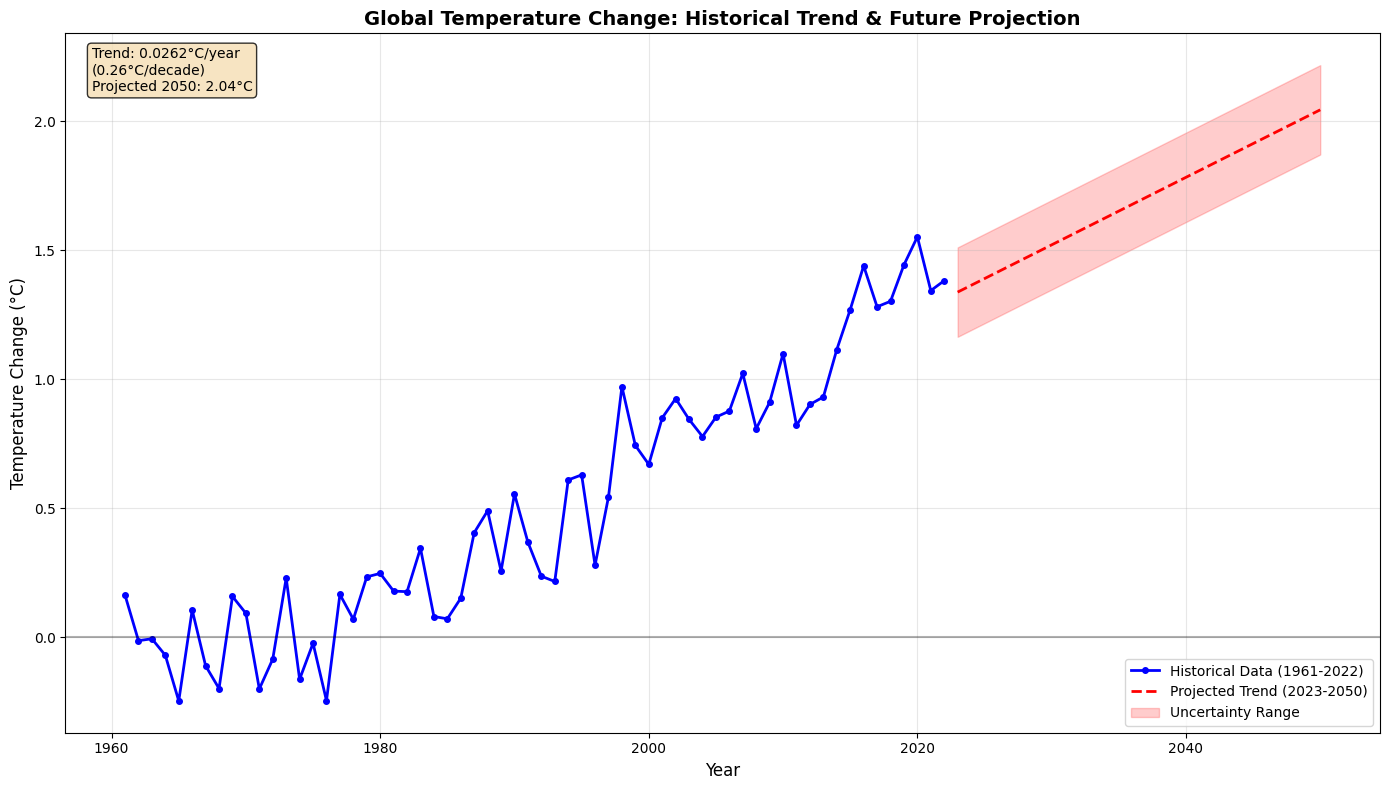

In [11]:
#Trend analysis and forecasting
# Prepare data for linear regression
trend_data = avg_temp.copy()
trend_data["Year_norm"] = trend_data["Year"] - 1961

X = trend_data[["Year_norm"]]
y = trend_data["Temperature"]

model = LinearRegression()
model.fit(X, y)

# Predict future trends
future_years = np.arange(2023, 2051)
future_years_norm = future_years - 1961
future_predictions = model.predict(future_years_norm.reshape(-1, 1))

# Create combined historical + future data
historical_years = trend_data["Year"].values
historical_temps = trend_data["Temperature"].values

all_years = np.concatenate([historical_years, future_years])
all_temps = np.concatenate([historical_temps, future_predictions])

# Plot with trend projection
plt.figure(figsize=(14, 8))

# Historical data
plt.plot(historical_years, historical_temps, 'o-', color='blue', 
         label="Historical Data (1961-2022)", linewidth=2, markersize=4)

# Future projection
plt.plot(future_years, future_predictions, 'r--', 
         label="Projected Trend (2023-2050)", linewidth=2)

# Add confidence interval
residuals = historical_temps - model.predict(X)
std_error = np.std(residuals)
plt.fill_between(future_years, 
                 future_predictions - std_error, 
                 future_predictions + std_error, 
                 alpha=0.2, color='red', label="Uncertainty Range")

plt.title("Global Temperature Change: Historical Trend & Future Projection", 
          fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature Change (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add trend information as text
trend_per_decade = model.coef_[0] * 10
plt.text(0.02, 0.98, f'Trend: {model.coef_[0]:.4f}°C/year\n({trend_per_decade:.2f}°C/decade)\n'
                      f'Projected 2050: {future_predictions[-1]:.2f}°C', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [12]:
#Statistical summary
print("="*60)
print("CLIMATE CHANGE ANALYSIS SUMMARY")
print("="*60)

print(f"\nGlobal Temperature Statistics (1961-2022):")
print(f"• Average annual temperature change: {avg_temp['Temperature'].mean():.3f}°C")
print(f"• Standard deviation: {avg_temp['Temperature'].std():.3f}°C")
print(f"• Maximum change: {avg_temp['Temperature'].max():.3f}°C in {avg_temp.loc[avg_temp['Temperature'].idxmax(), 'Year']}")
print(f"• Minimum change: {avg_temp['Temperature'].min():.3f}°C in {avg_temp.loc[avg_temp['Temperature'].idxmin(), 'Year']}")

# Decadal analysis
decade_avg = avg_temp.copy()
decade_avg["Decade"] = (decade_avg["Year"] // 10) * 10
decade_stats = decade_avg.groupby("Decade")["Temperature"].agg(['mean', 'std']).reset_index()

print(f"\nTemperature Change by Decade:")
for _, row in decade_stats.iterrows():
    print(f"• {int(row['Decade'])}s: {row['mean']:.3f}°C ± {row['std']:.3f}°C")

# Recent vs historical comparison
recent_decade = avg_temp[avg_temp['Year'] >= 2010]['Temperature'].mean()
historical_ref = avg_temp[avg_temp['Year'] <= 1990]['Temperature'].mean()
increase_since_ref = recent_decade - historical_ref

print(f"\nRecent vs Historical Comparison:")
print(f"• 2010-2022 average: {recent_decade:.3f}°C")
print(f"• 1961-1990 average: {historical_ref:.3f}°C")
print(f"• Increase since reference period: {increase_since_ref:.3f}°C")

CLIMATE CHANGE ANALYSIS SUMMARY

Global Temperature Statistics (1961-2022):
• Average annual temperature change: 0.513°C
• Standard deviation: 0.503°C
• Maximum change: 1.552°C in 2020
• Minimum change: -0.247°C in 1965

Temperature Change by Decade:
• 1960s: -0.024°C ± 0.148°C
• 1970s: 0.007°C ± 0.177°C
• 1980s: 0.240°C ± 0.138°C
• 1990s: 0.515°C ± 0.242°C
• 2000s: 0.854°C ± 0.094°C
• 2010s: 1.160°C ± 0.222°C
• 2020s: 1.426°C ± 0.111°C

Recent vs Historical Comparison:
• 2010-2022 average: 1.222°C
• 1961-1990 average: 0.094°C
• Increase since reference period: 1.128°C


In [13]:
#Extreme events analysis
print(f"\nExtreme Temperature Events:")
# Countries with highest warming
top_warming = pdf.nlargest(5, 'Change_1961_2022')[['Country', 'Change_1961_2022']]
print("Countries with highest warming (1961-2022):")
for idx, row in top_warming.iterrows():
    print(f"• {row['Country']}: +{row['Change_1961_2022']:.2f}°C")

# Countries with cooling or stable temperatures
stable_countries = pdf.nsmallest(3, 'Change_1961_2022')[['Country', 'Change_1961_2022']]
print("\nCountries with most stable temperatures:")
for idx, row in stable_countries.iterrows():
    change_str = "cooling" if row['Change_1961_2022'] < 0 else "stable"
    print(f"• {row['Country']}: {row['Change_1961_2022']:.2f}°C ({change_str})")


Extreme Temperature Events:
Countries with highest warming (1961-2022):
• Luxembourg: +2.76°C
• New Caledonia: +2.67°C
• Belgium: +2.64°C
• Kazakhstan, Rep. of: +2.55°C
• Andorra, Principality of: +2.51°C

Countries with most stable temperatures:
• Botswana: -1.46°C (cooling)
• Zimbabwe: -0.76°C (cooling)
• Marshall Islands, Rep. of the: -0.16°C (cooling)


In [14]:
#Regional analysis
print(f"\nRegional Analysis (2022 temperatures):")
continent_2022 = pdf.groupby('Continent')['F2022'].agg(['mean', 'std', 'count']).round(3)
print(continent_2022)


Regional Analysis (2022 temperatures):
            mean    std  count
Continent                     
Africa     0.970  0.248      5
Americas   1.068  0.278      5
Asia       1.534  0.407      9
Europe     2.356  0.380      6
Oceania    1.036  0.400      2
Other      1.367  0.656    198


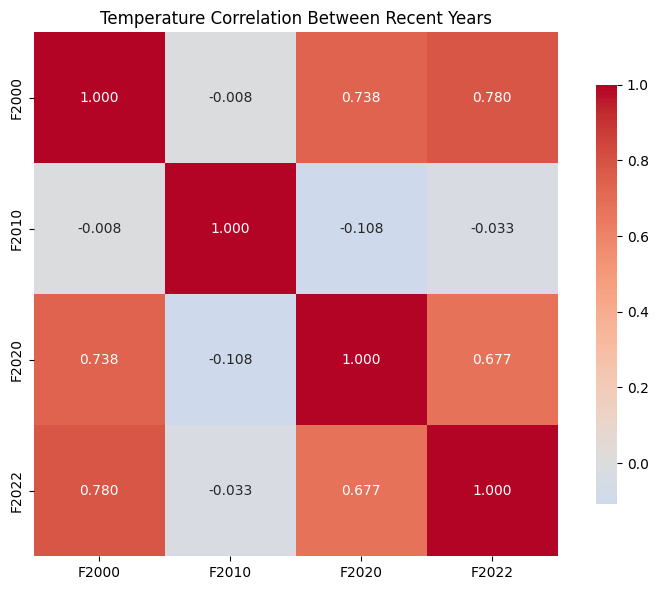

In [15]:
#Correlation heatmap for recent years
recent_year_cols = ['F2000', 'F2010', 'F2020', 'F2022']
corr_data = pdf[recent_year_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, cmap="coolwarm", center=0, 
            square=True, fmt=".3f", cbar_kws={"shrink": .8})
plt.title("Temperature Correlation Between Recent Years", fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
#Final insights and conclusions
print("="*60)
print("KEY INSIGHTS")
print("="*60)

insights = [
    "1. Global temperatures show a clear upward trend since 1961",
    "2. The warming rate appears to be accelerating in recent decades", 
    "3. Some regions are experiencing more rapid warming than others",
    "4. Projections suggest continued warming through 2050",
    "5. Temperature variability has increased over time"
]

for insight in insights:
    print(f"• {insight}")

print(f"\nRECOMMENDATIONS:")
print("• Continue monitoring temperature trends")
print("• Focus climate mitigation efforts on rapidly warming regions")
print("• Use these insights for climate adaptation planning")

# Cell 17: Stop Spark session
spark.stop()
print("\nAnalysis complete! Spark session stopped.")

KEY INSIGHTS
• 1. Global temperatures show a clear upward trend since 1961
• 2. The warming rate appears to be accelerating in recent decades
• 3. Some regions are experiencing more rapid warming than others
• 4. Projections suggest continued warming through 2050
• 5. Temperature variability has increased over time

RECOMMENDATIONS:
• Continue monitoring temperature trends
• Focus climate mitigation efforts on rapidly warming regions
• Use these insights for climate adaptation planning

Analysis complete! Spark session stopped.
